In [110]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import math
from google.colab.patches import cv2_imshow
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import cv2
from collections import Counter

In [111]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [112]:
#this function take image and number of colors which we want to identify in that image  and retun us the piechart with proportion of each color in image
#help user to identify which are approximate colors exist in image 
#K-means is base of this function to cluster close pixels to centroid and avg color
def piechart_colors(image, number_of_colors, show_chart): 

    resized_image = cv2.resize(image, (800, 600), interpolation = cv2.INTER_AREA) # to have less computation if the size of image is really huge(optional)
    reshaped_image = resized_image.reshape(resized_image.shape[0]*resized_image.shape[1], 3) #reshape image to be compatible with k-means algorithm
    
    clf = KMeans(n_clusters = number_of_colors)
    labels = clf.fit_predict(reshaped_image) 
    
    counts = Counter(labels)
    #print(counts)
    # sort to ensure correct color percentage
    counts = dict(sorted(counts.items()))
    #sort the dictionary of orderd color
    center_colors = clf.cluster_centers_
    ordered_colors = [center_colors[i] for i in counts.keys()]
    hex_colors = [RGB2HEX(ordered_colors[i]) for i in counts.keys()]
    rgb_colors = [ordered_colors[i] for i in counts.keys()]

    if (show_chart):
        plt.figure(figsize = (8, 6))
        plt.pie(counts.values(), labels = hex_colors, colors = hex_colors)
    return rgb_colors



In [113]:
def RGB2HEX(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))

In [114]:
def hex_to_rgb(hex):
  hex = hex.lstrip('#')
  hlen = len(hex)
  return tuple(int(hex[i:i + hlen // 3], 16) for i in range(0, hlen, hlen // 3))

In [115]:
def get_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

[array([175.8619318 , 208.98446265,  60.80025839]),
 array([249.45924027, 249.24867844, 247.86743543]),
 array([ 24.78812692,  42.38941816, 146.82741516]),
 array([210.87027567, 188.61767487, 166.8954079 ]),
 array([107.35875355, 100.17862216,  65.99227628]),
 array([31.83549469, 28.74041364, 21.46240917]),
 array([250.3761932 ,  75.54662642,  75.20249653]),
 array([ 81.56144096,  98.44643095, 219.97358239]),
 array([223.58911457, 218.34920272, 210.8178832 ]),
 array([166.51280687, 151.21975158, 132.84679629])]

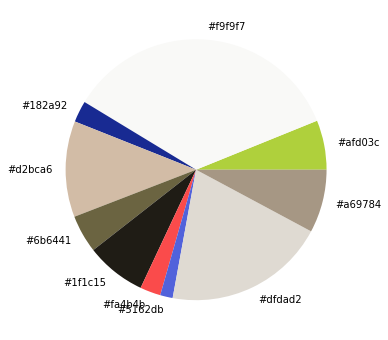

In [116]:
piechart_colors(get_image('//content/drive/MyDrive/shutterstock_277526549.jpg'),10 , True)

**The idea of this part is to Segment the image based on threshholding in HSV color space.**
HSV (Hue, Saturation, Value) is the model used to represent the RGB color in alignment to the human perception.

*   Hue: the Dominance of the Wavelength for the particular color
*   Saturation: the shades of the color 
*   Value: indicates the intensity of the color.

Thresholding is the process of creating a binary image by filtering out pixel based on a defined threshold. In our context, the threshold values will be HSV values denoting the range of “our specific segments' color”.
it is classifying the pixel values in an image. We decide a threshold values and classify the image in two parts one for pixel values greator than the threshold values and another for the smaller threshold values The HSV ranges can be obtained by doing a bit of trial and error or some automatic method like Ostu.

In [117]:
#with HSV is easier to get the complete range of one color. HSV, H stands for Hue, S for Saturation, V for value.
def rgb_to_hsv(color_string, th ):
    [Red, Green, Blue] =   Inputcolor #RGB COLOR  
    threshold = th 
    color = np.uint8([[[Blue, Green, Red]]])
    hsv_color = cv2.cvtColor(color, cv2.COLOR_BGR2HSV) # convert color from BGR ro hsv
    hue = hsv_color[0][0][0] #retrive hue of hsv image
    lower = max(0, hue - threshold)
    higher = min(360, hue + threshold)
    lowerer_range = np.array([lower, 50, 50], dtype=np.uint8)
    upper_range = np.array([higher, 255, 255], dtype=np.uint8)
    
    return lowerer_range, upper_range

**Build the MASK:**
imagine Mask as a colored transparent paper, imagine what happens if you put a colored transparent paper onto an image. It will magnify some part of the image and it will diminish other part of the image, depending on the color of the transparent paper or mask.

In [118]:
#mask
def color_detect(img, color, thres):
    hsv_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lowerer, higherer = rgb_to_hsv(color, thres)
    print(lowerer, higherer)
    mask = cv2.inRange(hsv_image, lowerer, higherer)  
    return mask, img

In [119]:
def round_up(n, decimals=0):
    multiplier = 10 ** decimals
    return math.ceil(n * multiplier) / multiplier

** Contours :**
Contours are the closed curve having the same color or intensity . For ex you have an image which consists of two 10 circle fruits in image what you think how many contours should be there? if you think its 10 you are 100% wrong. For most of the images there are many contours which are useless for us, since there is noise present in this image so the function takes those small pixels also as the closed curve!
for avoiding this we try to limit contours which are smaller than an specific sizes and we use some preprocessing methods like smoothing .

In [120]:
#take input hex color from user
print("please Enter the color you want to detect in the image!")
hexValue1 = input("Input your color in hex value")

print("\nAttensione. se non sai quali sono i colori esatti che esistono nell'immagine, consulta la tabella dei colori ")

Inputcolor = hex_to_rgb(hexValue1)
#Inputcolor =  [126, 179, 1]  
Input_Image = '/content/drive/MyDrive/shutterstock_277526549.jpg'  


please Enter the color you want to detect in the image!
Input your color in hex value182a93

Attensione. se non sai quali sono i colori esatti che esistono nell'immagine, consulta la tabella dei colori 


[106  50  50] [126 255 255]


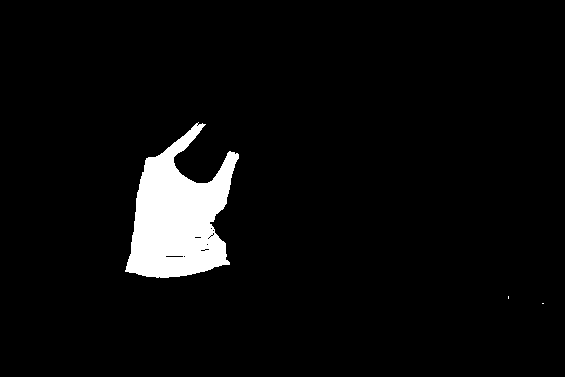

4.63 %
Number of sections in this color : 1


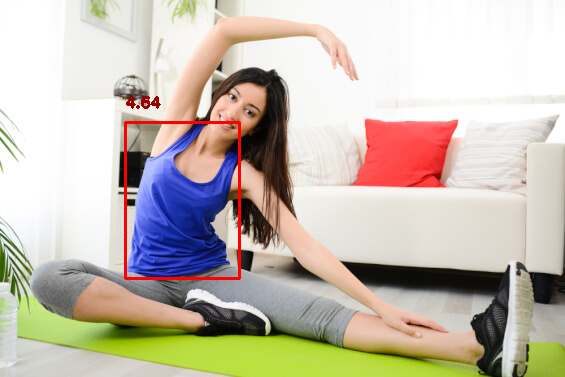

In [121]:
#Main
threshold = 10 
#threshhold is defined to consider non uniform color which are close to input color but a bit higher or lower in hue since
#must of the images in real world are not taken in isolate place and have different illumination and etc...

color =  Inputcolor
img = cv2.imread(Input_Image)
#print(img.shape)
mask,img = color_detect(img,color, threshold )
ret, bw_img = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
  
cv2_imshow (bw_img)
#cv2.waitKey(0)

result = img.copy()
#result = cv2.bilateralFilter(result,1,75,75)
height, width, channels = img.shape
image_area = width* height
#image_area #Input_Image.shape[0] * Input_Image.shape[1]
Noise_size = 500

#define contours 
contours = cv2.findContours(bw_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]
sec=0 
for cntr in contours:
  x,y,w,h = cv2.boundingRect(cntr)
  area = cv2.contourArea(cntr)
  #ignoring small size of noise for not contouring them
  if area > Noise_size:
    mask = np.zeros(result.shape, dtype=np.uint8)
    cv2.fillPoly(mask, [cntr], [255,255,255])
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    pixels = cv2.countNonZero(mask)
    #print(pixels)
    sec += 1
    #count number of pixels in each segment
    area_ratio = (area / image_area) * 100
    round_area_ratio = round(area_ratio,2)
    print(round_area_ratio, "%")
    cv2.rectangle(result, (x, y), (x+w, y+h), (0, 0, 255), 2)
    cv2.putText(result, '{}'.format(round_up(area_ratio,2)), (x,y - 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,155), 2)
print("Number of sections in this color :",sec)
    
cv2.imwrite('result.jpg',result)      
cv2_imshow( result)


please Enter the color you want to detect in the image!
Attensione. se non sai quali sono i colori esatti che esistono nell'immagine, consulta la tabella dei colori 
[24 50 50] [ 44 255 255]


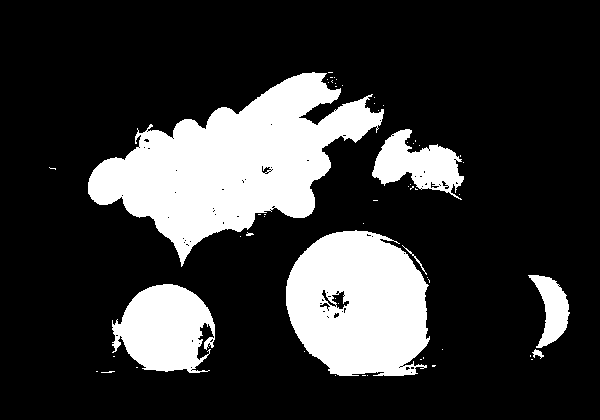

2.48 %
0.57 %
6.51 %
1.28 %
10.22 %
Number of sections in this color : 5


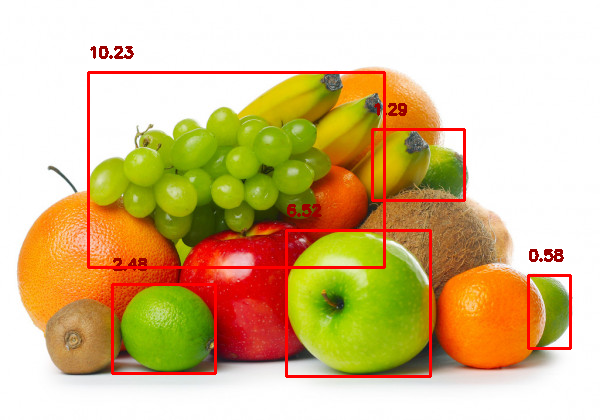

In [122]:
#Main
#another example with different method of taking input inside the program
print("please Enter the color you want to detect in the image!")
print("Attensione. se non sai quali sono i colori esatti che esistono nell'immagine, consulta la tabella dei colori ")
Inputcolor = hex_to_rgb("9cb506")
#Inputcolor =  [126, 179, 1]  
Input_Image = '/content/drive/MyDrive/depositphotos_8156139-stock-photo-fruits.jpg'  

threshold = 10 
#threshhold is defined to consider non uniform color which are close to input color but a bit higher or lower in hue since
#must of the images in real world are not taken in isolate place and have different illumination and etc...

color =  Inputcolor
img = cv2.imread(Input_Image)
#print(img.shape)
mask,img = color_detect(img,color, threshold )
ret, bw_img = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
  
cv2_imshow (bw_img)
#cv2.waitKey(0)

result = img.copy()
#result = cv2.bilateralFilter(result,1,75,75)
height, width, channels = img.shape
image_area = width* height
#image_area #Input_Image.shape[0] * Input_Image.shape[1]
Noise_size = 500

#define contours 
contours = cv2.findContours(bw_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]
sec=0 
for cntr in contours:
  x,y,w,h = cv2.boundingRect(cntr)
  area = cv2.contourArea(cntr)
  #ignoring small size of noise for not contouring them
  if area > Noise_size:
    mask = np.zeros(result.shape, dtype=np.uint8)
    cv2.fillPoly(mask, [cntr], [255,255,255])
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    pixels = cv2.countNonZero(mask)
    #print(pixels)
    sec += 1
    #count number of pixels in each segment
    area_ratio = (area / image_area) * 100
    round_area_ratio = round(area_ratio,2)
    print(round_area_ratio, "%")
    cv2.rectangle(result, (x, y), (x+w, y+h), (0, 0, 255), 2)
    cv2.putText(result, '{}'.format(round_up(area_ratio,2)), (x,y - 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,155), 2)
print("Number of sections in this color :",sec)
    
cv2.imwrite('result.jpg',result)      
cv2_imshow( result)
